<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/Kepler/Kepler_Light_Curve_Reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kepler Light Curve Reader

This is the main program used for
PHYS 549 to read and work with Kepler light curves.

In [1]:
#%matplotlib notebook
from astropy.io import fits
from astropy.table import Table 
import matplotlib.pyplot as plt

## Using Kepler data from MAST to plot a light curve

[Tutorial Link](https://spacetelescope.github.io/notebooks/notebooks/MAST/Kepler/Kepler_Lightcurve/kepler_lightcurve.html)

*Note as of 10/15/22:* We will now use [*lightkurve*](https://docs.lightkurve.org/index.html) for data acquisition of Kepler LCs. 

In [2]:
# Import libraries from astroquery
from astroquery.mast import Mast
from astroquery.mast import Observations

In [3]:
# Search MAST portal for data of a particular Kepler target (target name, spacecraft)

keplerObs = Observations.query_criteria(target_name='kplr011446443', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[1])
yourProd = Observations.filter_products(keplerProds, extension='kplr011446443-2009131110544_slc.fits', 
                                        mrp_only=False)
yourProd



obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str60,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
601031,Kepler,timeseries,kplr011446443_sc_Q113313330333033302,Lightcurve Short Cadence (CSC) - Q0,C,mast:KEPLER/url/missions/kepler/lightcurves/0114/011446443/kplr011446443-2009131110544_slc.fits,SCIENCE,Minimum Recommended Products,SLC,--,Kepler,--,EX_STKS,kplr011446443-2009131110544_slc.fits,1457280,601031,PUBLIC,2


In [4]:
# Download the data file

Observations.download_products(yourProd, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str95,str8,object,object
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits,COMPLETE,None,None


In [5]:
# See some information about the FITS Header Data Units:

filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits"
fits.info(filename)



Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   14280R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 9)   int32   


In [6]:
# Opens the FITS file, writes the first HDU extension into header1, and then closes the file

with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[0:24])) #repr() prints the info into neat columns

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                14280 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [7]:
# View a table of the data from the Binary Table extension. This is where we can find the flux and time columns to be plotted later.

with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytable = Table(binaryext)
binarytable[1:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52992386784899,0.00096672785,5501,401288.16,91.51187,2598.1086,0.5752603,406100.9,127.528824,0,nan,nan,nan,nan,621.2181187542091,0.0002101067,848.8972881655714,0.00029125414,0.0002031729,-0.0025746305
120.53060508973431,0.00096674974,5502,401425.53,91.53448,2598.0261,0.57525027,406242.22,125.212105,0,nan,nan,nan,nan,621.2190207168474,0.00021018942,848.8935790650855,0.0002912894,0.00021144762,-0.0025837936
120.53128621167707,0.0009667717,5503,401172.0,91.517265,2597.9438,0.5752402,405984.03,123.31339,0,nan,nan,nan,nan,621.2179228162092,0.00021032244,848.894852260174,0.0002914222,0.00021972114,-0.0025929555
120.53196743356966,0.00096679357,5504,401473.62,91.53064,2597.8613,0.5752302,406293.0,121.84987,0,nan,nan,nan,nan,621.2198263101714,0.00021020704,848.8961790332079,0.00029115527,0.00022799587,-0.0026021185


In [8]:
# Convert the time to Barycentric Julian Days and read relevant LC data

with fits.open(filename, mode="readonly") as hdulist:
    # Read in the "BJDREF" which is the time offset of the time array.
    bjdrefi = hdulist[1].header['BJDREFI'] 
    bjdreff = hdulist[1].header['BJDREFF']

    # Read in the columns of data.
    times = hdulist[1].data['time'] 
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

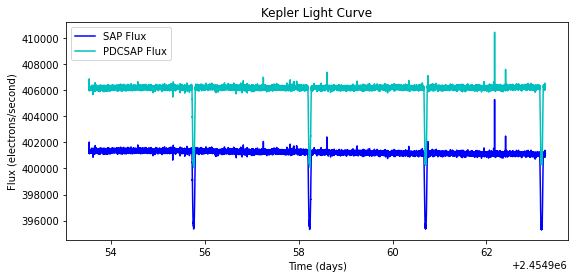

In [9]:
# Convert the time array to full BJD by adding the offset back in.
bjds = times + bjdrefi + bjdreff 

plt.figure(figsize=(9,4))

# Plot the time, uncorrected and corrected fluxes.
plt.plot(bjds, sap_fluxes, '-b', label='SAP Flux') 
plt.plot(bjds, pdcsap_fluxes, '-c', label='PDCSAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')
plt.savefig('sample_LCs.png')

## Using the *lightkurve* package to load and plot a Kepler LC

Tutorial Link: https://docs.lightkurve.org/quickstart.html

In [10]:
# Read Kepler Object of Interest Table and drop FALSE POSITIVES

import pandas as pd
from io import StringIO

df_koi = pd.read_csv('KOI.csv')
df_koi_set = df_koi[df_koi['koi_disposition'] != 'FALSE POSITIVE'] # 4725 rows
print(len(df_koi_set))

4725


In [22]:
from lightkurve import search_targetpixelfile

example_KIC = "10811496"

# obtain the Kepler pixel data for the star from the data archive
pixelfile = search_targetpixelfile("KIC "+example_KIC, quarter=16).download();

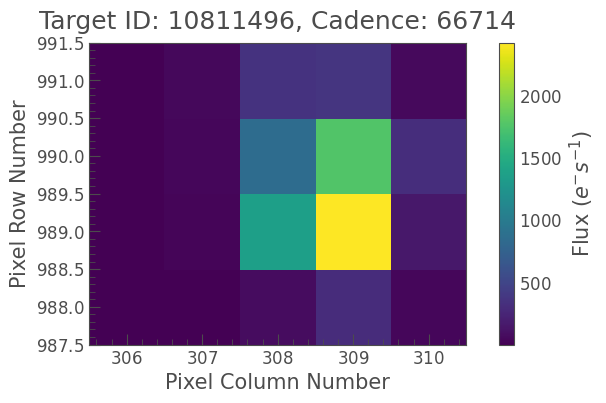

In [12]:
# Display the first image in this data set 

pixelfile.plot(frame=1);

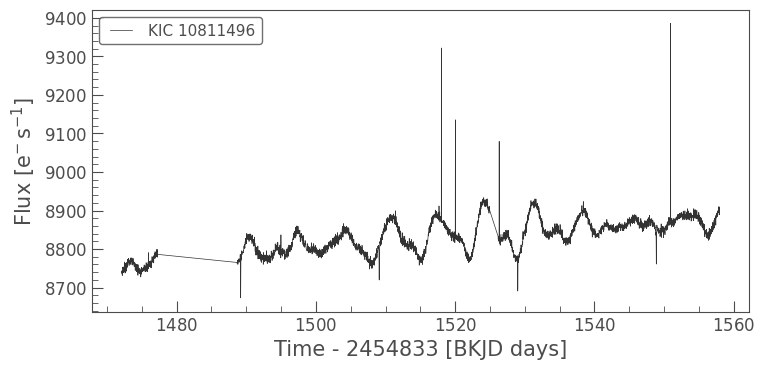

In [13]:
# The star is an isolated object,  so we can extract a light curve by simply
# summing up all the pixel values in each image:
lc = pixelfile.to_lightcurve(aperture_mask='all');
lc.time # in BJDs
lc.flux # number of photons received by spacecraft, converted to current (e-/sec)
lc.plot(); 



In [14]:
print("Number of flux data points in "+example_KIC+": "+str(len(lc.flux)))

Number of flux data points in 10811496: 3540


## Working with Kepler Light Curve Data from Kepler Object of Interest (KOI) Table



[Link to KOI data columns dictionary](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)

### Estimate exoplanet radii using neural network regression

Notes:

*   **X**: The input data
  *   `koi_period` = orbital period (days)
  *   `koi_time0bk` = transit epoch, or the time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days
  *   `koi_impact` = impact parameter
  *   `koi_duration` = duration (hours)
  *   `koi_depth` = depth (parts per million)
  *   planet mass
*   **Y**: The target values (radii)

[link to sklearn regression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

[link to KOI data columns dictionary](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)


Import the necessary libraries


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import neural_network
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sys

From the KOI table, we  filter all non-`CONFIRMED` rows to extract input parameters and known exoplanet radii.
<br/>
<br/>

The planet mass is calculated by multiplying,
<br/>
$g_{*}R_{*}^2$
<br/>
where $g_{*}$ is the stellar surface gravity and $R_{*}$ is the stellar radius.
<br/>
<br/>

We split the data 50% **training**, 25% **testing**, and 25% **validation**.

In [16]:
# KOI filtering 
KOI = pd.read_csv('KOI.csv')
KOI_confirmed = KOI.drop(KOI[KOI['koi_disposition']!='CONFIRMED'].index)

# planet mass calculation
mass = KOI_confirmed['koi_slogg'].mul(KOI_confirmed['koi_srad'].mul(KOI_confirmed['koi_srad']))

# extract input parameters and split the dat
x = KOI_confirmed[['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth']]
x.loc[:,'mass'] = pd.Series(np.random.randn(len(x)), index=x.index)
x.loc[:, 'mass'] = mass
y = KOI_confirmed[['koi_prad']]
x = x.fillna(0)
y = y.fillna(0)
from sklearn import preprocessing
x_scaled = preprocessing.scale(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled[1:6000], y[1:6000], train_size=0.5, test_size=0.25)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


View the inputs

In [17]:
x

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,mass
0,9.488036,170.53875,0.146,2.9575,615.8,3.838623
1,54.418383,162.51384,0.586,4.5070,874.8,3.838623
4,2.525592,171.59555,0.701,1.6545,603.3,4.855687
5,11.094321,171.20116,0.538,4.5945,1517.5,4.238301
6,4.134435,172.97937,0.762,3.1402,686.0,4.238301
...,...,...,...,...,...,...
8057,10.692115,141.11600,0.734,4.6570,408.4,6.649993
8817,4.485592,135.43172,0.442,0.8161,2265.0,0.189858
8956,8.152759,134.19046,0.461,1.7460,16536.0,0.182641
9014,384.847556,314.97000,0.059,9.9690,189.9,2.916562


View the outputs

In [18]:
y


,koi_prad
0,2.26
1,2.83
4,2.75
5,3.90
6,2.77
...,...
8057,2.71
8817,0.95
8956,2.44
9014,1.09


Define two functions to attempt the regression twice

In [19]:
def test_validate1(x_test, y_test, y_predict, classifier):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, y_predict, "bo", markersize=8, zorder=2, label=u"predicted, $R$=%.3f" % classifier.score(x_test, y_test))
    plt.legend(loc="upper left", prop={'size': 14})
    plt.xlabel("Number", fontsize = 14)
    plt.ylabel("Planet Radius " + r"$(R_{earth})$", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, 100, -10,50])
    plt.show()

def test_validate2(x_test, y_test, y_predict, classifier):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, y_predict, "bo", markersize=8, zorder=2, label=u"predicted, $R$=%.3f" % classifier.score(x_test, y_test))
    plt.legend(loc="lower left", prop={'size': 14})
    plt.xlabel("Number", fontsize = 14)
    plt.ylabel("Planet Radius " + r"$(R_{earth})$", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, 100, -3,10])
    plt.show()

plt.rcParams["figure.figsize"] = (10,7)

Now use Multi-layer Perceptron regressor

This model optimizes the squared error using LBFGS or stochastic gradient descent

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


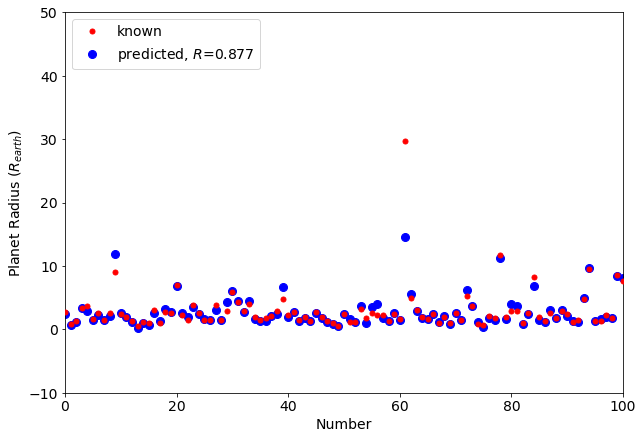

In [20]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes=(100, 20), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 power_t=0.5, max_iter=1000,tol=1e-4)

mlp.fit(x_train, y_train)
r = mlp.score(x_train, y_train)
y_predict = mlp.predict(x_test)  
test_validate1(x_test=x_test, y_test=y_test, y_predict=y_predict, classifier=mlp)


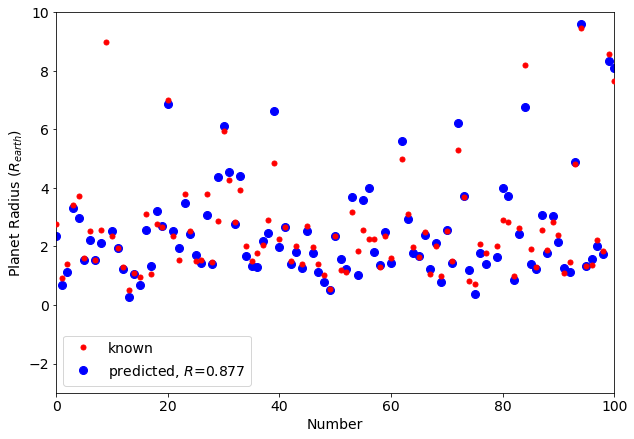

In [21]:
test_validate2(x_test=x_test, y_test=y_test, y_predict=y_predict, classifier=mlp)